In [366]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
#设置中文显示
plt.rcParams['font.sans-serif']=['SimHei']
# 解决负号无法显示的问题
plt.rcParams['axes.unicode_minus'] =False

In [367]:
#导入数据,数据无表头，需设置header=None
df5 = pd.read_csv('datasets\capacity_7.csv',header=None)
df6 = pd.read_csv('datasets\capacity_6.csv',header=None)
df7 = pd.read_csv('datasets\capacity_5.csv',header=None)
df18 = pd.read_csv('datasets\capacity_18.csv',header=None)

#转换为numpy数组
capacity_5 = df5.values
capacity_6 = df6.values
capacity_7 = df7.values
capacity_18 = df18.values
real_5=capacity_5
real_6=capacity_6
real_7=capacity_7
real_18=capacity_18

In [368]:
#统一归一化
scaler = MinMaxScaler(feature_range=(0, 1))
capacity=np.vstack((capacity_5,capacity_6,capacity_7,capacity_18))
scaler.fit_transform(capacity)
capacity_5 = scaler.transform(capacity_5)
capacity_6 = scaler.transform(capacity_6)
capacity_7 = scaler.transform(capacity_7)
capacity_18 = scaler.transform(capacity_18)

In [369]:
#转换为时间序列数据
window_size=3
def time_series(dataset, window_size):
    data_X, data_Y = [], []
    for i in range(len(dataset)-window_size):
        a = dataset[i:(i+window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return np.array(data_X), np.array(data_Y).reshape(-1,1)


sequ_x_5,sequ_y_5 = time_series(capacity_5, window_size)
sequ_x_6,sequ_y_6 = time_series(capacity_6, window_size)
sequ_x_7,sequ_y_7 = time_series(capacity_7, window_size)
sequ_x_18,sequ_y_18 = time_series(capacity_18, window_size)
_,y_5=time_series(real_5,window_size)
_,y_6=time_series(real_6,window_size)
_,y_7=time_series(real_7,window_size)
_,y_18=time_series(real_18,window_size)


In [370]:
#连接数据
sequ_x=np.vstack((sequ_x_5,sequ_x_6,sequ_x_7,sequ_x_18))
sequ_y=np.vstack((sequ_y_5,sequ_y_6,sequ_y_7,sequ_y_18))
sequ_x_5.shape,sequ_y.shape


((165, 3), (624, 1))

In [371]:
#构建LSTM模型
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# #搭建LSTM模型
# model = Sequential()
# model.add(LSTM(units=50, return_sequences=True, input_shape=(sequ_x.shape[1],1)))
# model.add(Dropout(0.2))
# model.add(LSTM(units=50))
# model.add(Dropout(0.2))
# model.add(Dense(units=1))
# model.compile(optimizer='adam', loss='mean_squared_error')
# model.fit(sequ_x, sequ_y, epochs=100, batch_size=32)

# #预测
# y_pred_5 = model.predict(sequ_x_5)
# #反归一化
# y_pred_5 = scaler.inverse_transform(y_pred_5)


In [372]:
# plt.plot(y_5, color = 'red', label = 'Real capacity')
# plt.plot(y_pred_5, color = 'blue', label = 'Predicted capacity')
# plt.title('capacity prediction')
# plt.xlabel('Cycle')
# plt.ylabel('capacity')
# plt.legend()
# plt.show()

In [373]:
#搭建模型的函数，方便调参
def build_model(window_size=3,dropout=0.2,activation='relu',lstm_size=50):
    model = Sequential()
    model.add(LSTM(units=lstm_size, return_sequences=True, input_shape=(window_size,1)))
    model.add(Dropout(dropout))
    model.add(LSTM(units=lstm_size))
    model.add(Dropout(dropout))
    #model.add(Dense(units=lstm_size,activation=activation,kernel_initializer='uniform'))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [374]:
# #超参数调优，使用网格搜索
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor 
# from sklearn.model_selection import GridSearchCV
# from keras.callbacks import EarlyStopping
# model = KerasRegressor(build_fn=build_model)
# param_grid = {
#     #'window_size':[3,5,7],
#     'dropout':[0.2,0.3,0.4],
#     'activation':['relu','tanh'],
#     'lstm_size':[20,50,80],
# }
# grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=3,n_jobs=1,verbose=2)
# callbacks=[EarlyStopping(monitor='loss',patience=5,min_delta=1e-4,verbose=0)]
# grid_result = grid.fit(sequ_x, sequ_y,validation_data = (sequ_x_5, sequ_y_5), epochs=100, batch_size=32,verbose=0,callbacks=callbacks)
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))



In [375]:
#使用最优参数搭建模型
# dropout=grid_result.best_params_['dropout']
# activation=grid_result.best_params_['activation']
# lstm_size=grid_result.best_params_['lstm_size']

dropout=0.2
activation='tanh'
lstm_size=80

model = build_model(window_size=window_size,dropout=dropout,activation=activation,lstm_size=lstm_size)
model.fit(sequ_x, sequ_y, epochs=200, batch_size=32)

#预测
y_pred_5 = model.predict(sequ_x_5)
#反归一化
y_pred_5 = scaler.inverse_transform(y_pred_5)




Epoch 1/200
20/20 [==============================] - 2s 7ms/step - loss: 0.1211
Epoch 2/200
20/20 [==============================] - 0s 7ms/step - loss: 0.0171
Epoch 3/200
20/20 [==============================] - 0s 7ms/step - loss: 0.0080
Epoch 4/200
20/20 [==============================] - 0s 7ms/step - loss: 0.0044
Epoch 5/200
20/20 [==============================] - 0s 8ms/step - loss: 0.0026
Epoch 6/200
20/20 [==============================] - 0s 7ms/step - loss: 0.0025
Epoch 7/200
20/20 [==============================] - 0s 7ms/step - loss: 0.0024
Epoch 8/200
20/20 [==============================] - 0s 8ms/step - loss: 0.0022
Epoch 9/200
20/20 [==============================] - 0s 7ms/step - loss: 0.0025
Epoch 10/200
20/20 [==============================] - 0s 7ms/step - loss: 0.0021
Epoch 11/200
20/20 [==============================] - 0s 6ms/step - loss: 0.0024
Epoch 12/200
20/20 [==============================] - 0s 6ms/step - loss: 0.0023
Epoch 13/200
20/20 [=================

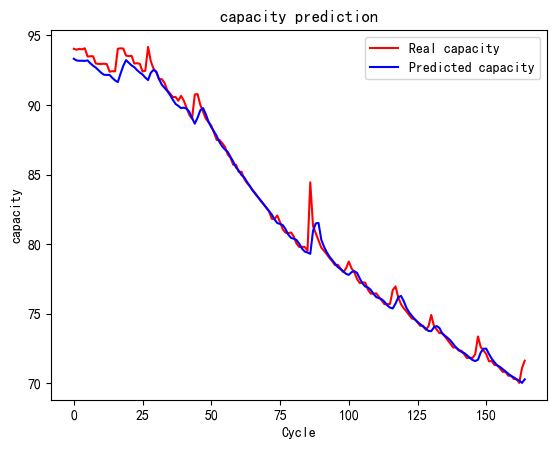

rmse: 0.6960963490812955
mape: 0.4692554901639865


In [376]:
#画图
plt.plot(y_5, color = 'red', label = 'Real capacity')
plt.plot(y_pred_5, color = 'blue', label = 'Predicted capacity')
plt.title('capacity prediction')
plt.xlabel('Cycle')
plt.ylabel('capacity')
plt.legend()
plt.show()

#评估模型
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

rmse=np.sqrt(mean_squared_error(y_5,y_pred_5))
mape=np.mean(np.abs((y_5-y_pred_5)/y_5))*100

print('rmse:',rmse)
print('mape:',mape)


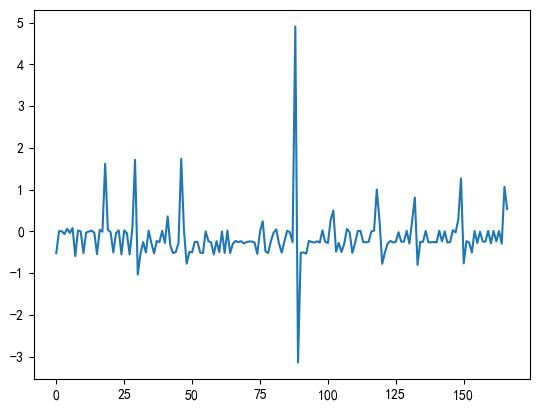

In [377]:
#RF对比
from sklearn.ensemble import RandomForestRegressor
#生成残差序列
head5=real_5[window_size]
head6=real_6[window_size]
head7=real_7[window_size]
head18=real_18[window_size]

diff5=np.diff(real_5.reshape(-1,1),axis = 0).reshape(-1,1)
diff6=np.diff(real_6,axis = 0).reshape(-1,1)
diff7=np.diff(real_7,axis = 0).reshape(-1,1)
diff18=np.diff(real_18,axis = 0).reshape(-1,1)

plt.plot(diff5)

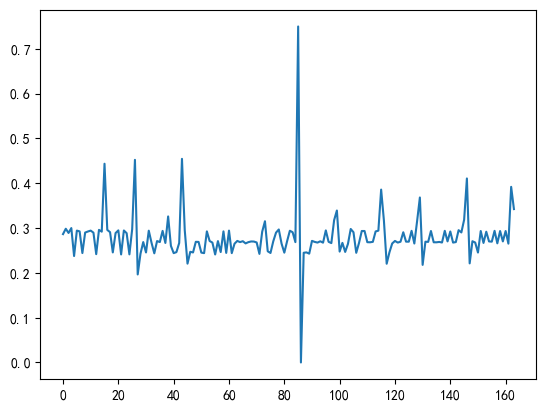

In [378]:

#标准化
rf_scaler=MinMaxScaler(feature_range=(0,1))
diff=np.vstack((diff5,diff6,diff7,diff18)).reshape(-1,1)

rf_scaler.fit_transform(diff)
diff5=rf_scaler.transform(diff5)
diff6=rf_scaler.transform(diff6.reshape(-1,1))
diff7=rf_scaler.transform(diff7.reshape(-1,1))
diff18=rf_scaler.transform(diff18.reshape(-1,1))

def_seq5_x,def_seq5_y=time_series(diff5,window_size)
def_seq6_x,def_seq6_y=time_series(diff6,window_size)
def_seq7_x,def_seq7_y=time_series(diff7,window_size)
def_seq18_x,def_seq18_y=time_series(diff18,window_size)

def_seq_x=np.vstack((def_seq5_x,def_seq6_x,def_seq7_x,def_seq18_x))
def_seq_y=np.vstack((def_seq5_y,def_seq6_y,def_seq7_y,def_seq18_y))

plt.plot(def_seq5_y)


C:\Users\18711\AppData\Local\Temp\ipykernel_1792\3358632416.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(def_seq_x,def_seq_y)


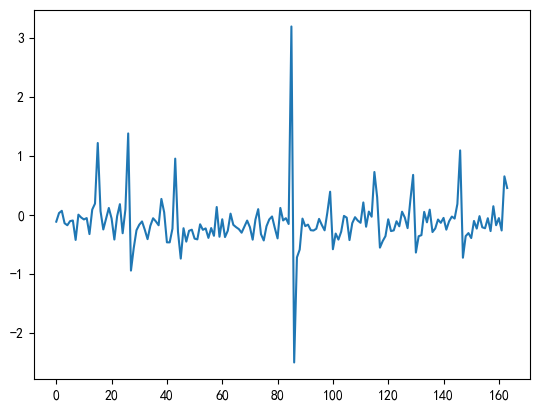

In [379]:

#训练模型
rf=RandomForestRegressor()
rf.fit(def_seq_x,def_seq_y)

#预测
y_pred_5_rf=rf.predict(def_seq5_x)
y_pred_5_rf=y_pred_5_rf.reshape(-1,1)

y_pred_5_rf=rf_scaler.inverse_transform(y_pred_5_rf)
plt.plot(y_pred_5_rf)

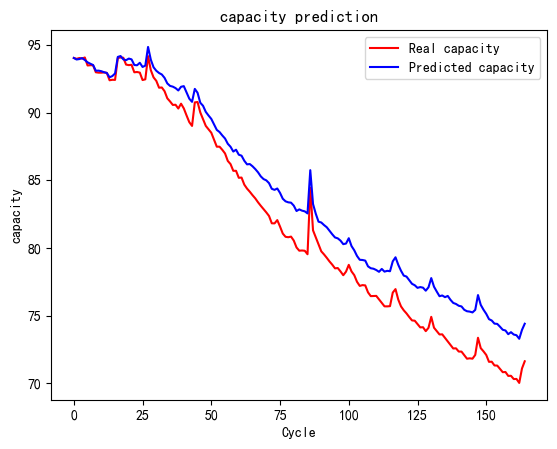

In [380]:

y_sequ_pred=np.zeros((len(y_pred_5_rf)+1,1))

#恢复原始序列
for i in range(len(y_pred_5_rf)+1):
    if(i==0):
        y_sequ_pred[i]=head5
    else:
        y_sequ_pred[i]=y_sequ_pred[i-1]+y_pred_5_rf[i-1]

#画图
plt.plot(y_5, color = 'red', label = 'Real capacity')
plt.plot(y_sequ_pred, color = 'blue', label = 'Predicted capacity')
plt.title('capacity prediction')
plt.xlabel('Cycle')
plt.ylabel('capacity')
plt.legend()
plt.show()




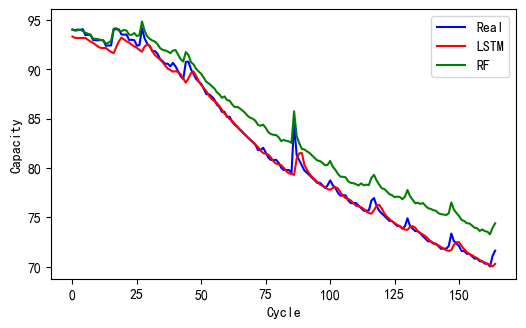

rmse: 0.6960963490812955
mae: 0.394786083603605
mape: 0.4692554901639865
rmse_rf: 2.1833355305220814
mae_rf: 1.925593518757045
mape_rf: 2.4831063915155815


In [381]:
#画图对比
plt.figure(figsize=(6,3.5))
plt.plot(y_5, color = 'blue', label = 'Real')
plt.plot(y_pred_5, color = 'red', label = 'LSTM')
plt.plot(y_sequ_pred, color = 'green', label = 'RF')

plt.xlabel('Cycle')
plt.ylabel('Capacity')
plt.legend()
plt.show()

#评估模型
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
rmse=np.sqrt(mean_squared_error(y_5,y_pred_5))
mae=mean_absolute_error(y_5,y_pred_5)
mape=np.mean(np.abs((y_5-y_pred_5)/y_5))*100

print('rmse:',rmse)
print('mae:',mae)
print('mape:',mape)

rmse_rf=np.sqrt(mean_squared_error(y_5,y_sequ_pred))
mae_rf=mean_absolute_error(y_5,y_sequ_pred)
mape_rf=np.mean(np.abs((y_5-y_sequ_pred)/y_5))*100

print('rmse_rf:',rmse_rf)
print('mae_rf:',mae_rf)
print('mape_rf:',mape_rf)





In [382]:
#迭代预测
def recursive_predict(X,threshold):
    y_list=[]
    y_pred = model.predict(X.reshape(-1,window_size,1))
    while(y_pred[0][0]>=threshold):
        y_list.append(y_pred)
        X=np.vstack((X[1:],y_pred.reshape(-1,1)))
        y_pred = model.predict(X.reshape(-1,window_size,1))

    return y_list

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164


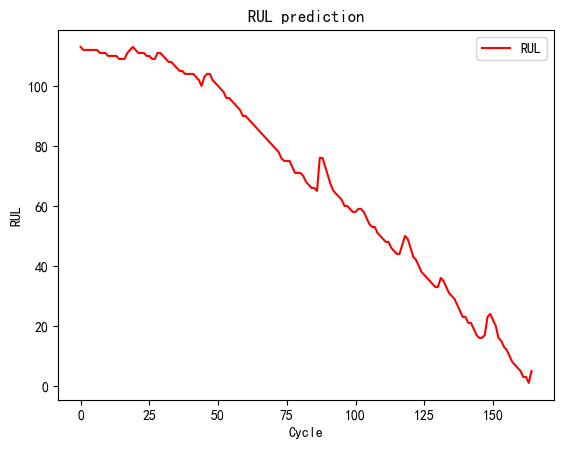

In [383]:
#迭代过程
threshold=70
threshold_norm=scaler.transform(np.array(threshold).reshape(-1,1))
threshold_norm=threshold_norm[0][0]

rul_list=[]
for i in range(len(sequ_x_5)):
    print(i)
    if(sequ_x_5[i][-1]<threshold_norm):
        break
    pred_list=recursive_predict(sequ_x_5[i].reshape(-1,1),threshold_norm)
    rul_list.append(len(pred_list))


#画图
plt.plot(rul_list, color = 'red', label = 'RUL')
plt.title('RUL prediction')
plt.xlabel('Cycle')
plt.ylabel('RUL')
plt.legend()
plt.show()


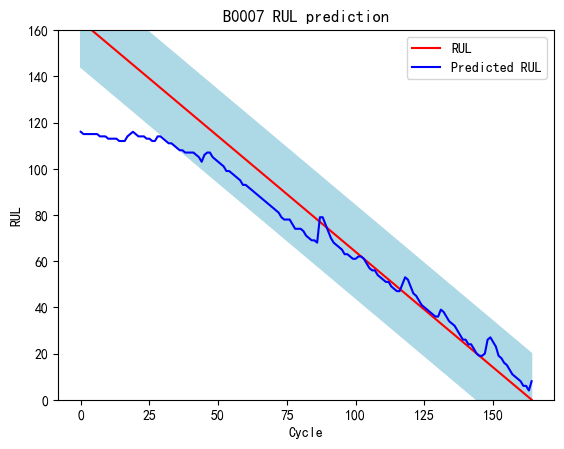

0.9522392701637985
0.8613015253920338


In [391]:
for i in range(len(real_5)):
    if(real_5[i]<threshold):
        break
threshold_point=i

#生成RUL
rul=np.zeros(i+1)
for i in range(len(rul)):
    rul[i]=threshold_point-i

rul_pred=np.array(rul_list)+window_size
rul_pred=(rul_pred-rul[window_size:])/1+rul[window_size:]
#化为整数
rul_pred=np.round(rul_pred)

#画图
plt.plot(rul[window_size:], color = 'red', label = 'RUL')
plt.plot(rul_pred, color = 'blue', label = 'Predicted RUL')

#在rul上下距离20的范围内画出淡蓝色区域
plt.fill_between(np.arange(len(rul[window_size:])),rul[window_size:]-20,rul[window_size:]+20,color='lightblue')

plt.title('B0007 RUL prediction')
plt.xlabel('Cycle')
plt.ylabel('RUL')
#y轴下界
plt.ylim(0,160)
plt.legend()
plt.show()

#计算线性拟合的R2
from sklearn.metrics import r2_score
print(r2_score(rul[window_size+60:],rul_pred[60:]))
print(r2_score(rul[window_size:],rul_pred[:]))


In [385]:
# #实验window_size对预测结果的影响
# window_size_list=[3,4,5,6,7]
# rmse_list1=[]
# rmse_list2=[]
# rmse_list3=[]
# rmse_list4=[]
# for window_size_test in window_size_list:
#     sequ_x_5,sequ_y_5 = time_series(capacity_5, window_size_test)
#     sequ_x_6,sequ_y_6 = time_series(capacity_6, window_size_test)
#     sequ_x_7,sequ_y_7 = time_series(capacity_7, window_size_test)
#     sequ_x_18,sequ_y_18 = time_series(capacity_18, window_size_test)
#     _,y_5=time_series(real_5,window_size_test)
#     _,y_6=time_series(real_6,window_size_test)
#     _,y_7=time_series(real_7,window_size_test)
#     _,y_18=time_series(real_18,window_size_test)
#     sequ_x=np.vstack((sequ_x_6,sequ_x_7,sequ_x_18))
#     sequ_y=np.vstack((sequ_y_6,sequ_y_7,sequ_y_18))
#     model=build_model(window_size=window_size_test,dropout=0.2,activation='tanh',lstm_size=80)
#     model.fit(sequ_x_5, sequ_y_5, epochs=100, batch_size=32)
#     y_pred_5 = model.predict(sequ_x_5)
#     y_pred_5 = scaler.inverse_transform(y_pred_5)

#     rmse=np.sqrt(np.mean(y_pred_5-y_5)**2)
#     rmse_list1.append(rmse)


# for window_size_test in window_size_list:
#     sequ_x_5,sequ_y_5 = time_series(capacity_5, window_size_test)
#     sequ_x_6,sequ_y_6 = time_series(capacity_6, window_size_test)
#     sequ_x_7,sequ_y_7 = time_series(capacity_7, window_size_test)
#     sequ_x_18,sequ_y_18 = time_series(capacity_18, window_size_test)
#     _,y_5=time_series(real_5,window_size_test)
#     _,y_6=time_series(real_6,window_size_test)
#     _,y_7=time_series(real_7,window_size_test)
#     _,y_18=time_series(real_18,window_size_test)
#     sequ_x=np.vstack((sequ_x_5,sequ_x_7,sequ_x_18))
#     sequ_y=np.vstack((sequ_y_5,sequ_y_7,sequ_y_18))
#     model=build_model(window_size=window_size_test,dropout=0.2,activation='tanh',lstm_size=80)
#     model.fit(sequ_x_6, sequ_y_6, epochs=100, batch_size=32)
#     y_pred = model.predict(sequ_x_6)
#     y_pred = scaler.inverse_transform(y_pred)

#     rmse=np.sqrt(np.mean(y_pred-y_6)**2)
#     rmse_list2.append(rmse)

# for window_size_test in window_size_list:
#     sequ_x_5,sequ_y_5 = time_series(capacity_5, window_size_test)
#     sequ_x_6,sequ_y_6 = time_series(capacity_6, window_size_test)
#     sequ_x_7,sequ_y_7 = time_series(capacity_7, window_size_test)
#     sequ_x_18,sequ_y_18 = time_series(capacity_18, window_size_test)
#     _,y_5=time_series(real_5,window_size_test)
#     _,y_6=time_series(real_6,window_size_test)
#     _,y_7=time_series(real_7,window_size_test)
#     _,y_18=time_series(real_18,window_size_test)
#     sequ_x=np.vstack((sequ_x_5,sequ_x_6,sequ_x_18))
#     sequ_y=np.vstack((sequ_y_5,sequ_y_6,sequ_y_18))
#     model=build_model(window_size=window_size_test,dropout=0.2,activation='tanh',lstm_size=80)
#     model.fit(sequ_x_7, sequ_y_7, epochs=100, batch_size=32)
#     y_pred = model.predict(sequ_x_7)
#     y_pred = scaler.inverse_transform(y_pred)

#     rmse=np.sqrt(np.mean(y_pred-y_7)**2)
#     rmse_list3.append(rmse)

# for window_size_test in window_size_list:
#     sequ_x_5,sequ_y_5 = time_series(capacity_5, window_size_test)
#     sequ_x_6,sequ_y_6 = time_series(capacity_6, window_size_test)
#     sequ_x_7,sequ_y_7 = time_series(capacity_7, window_size_test)
#     sequ_x_18,sequ_y_18 = time_series(capacity_18, window_size_test)
#     _,y_5=time_series(real_5,window_size_test)
#     _,y_6=time_series(real_6,window_size_test)
#     _,y_7=time_series(real_7,window_size_test)
#     _,y_18=time_series(real_18,window_size_test)
#     sequ_x=np.vstack((sequ_x_5,sequ_x_6,sequ_x_7))
#     sequ_y=np.vstack((sequ_y_5,sequ_y_6,sequ_y_7))
#     model=build_model(window_size=window_size_test,dropout=0.2,activation='tanh',lstm_size=80)
#     model.fit(sequ_x_18, sequ_y_18, epochs=100, batch_size=32)
#     y_pred = model.predict(sequ_x_18)
#     y_pred = scaler.inverse_transform(y_pred)

#     rmse=np.sqrt(np.mean(y_pred-y_18)**2)
#     rmse_list4.append(rmse)

# rmse_list=[]
# for i in range(len(window_size_list)):
#     rmse_list.append((rmse_list1[i]+rmse_list2[i]+rmse_list3[i]+rmse_list4[i])/4)




# plt.bar(window_size_list,rmse_list)
# plt.title('RMSE of different window_size')
# plt.xlabel('window_size')
# plt.ylabel('RMSE')
# plt.show()



In [386]:
# plt.figure(figsize=(8,5))
# plt.bar(window_size_list,rmse_list,width=0.6)
# plt.title('RMSE of different window_size')
# plt.xlabel('window_size')
# plt.ylabel('RMSE')
# plt.show()

In [387]:
# #实验window_size对预测结果的影响
# window_size_list=[3,4,5,6,7]
# rmse_list=[]
# for window_size_test in window_size_list:
#     sequ_x_5,sequ_y_5 = time_series(capacity_5, window_size_test)
#     sequ_x_6,sequ_y_6 = time_series(capacity_6, window_size_test)
#     sequ_x_7,sequ_y_7 = time_series(capacity_7, window_size_test)
#     sequ_x_18,sequ_y_18 = time_series(capacity_18, window_size_test)
#     _,y_5=time_series(real_5,window_size_test)
#     _,y_6=time_series(real_6,window_size_test)
#     _,y_7=time_series(real_7,window_size_test)
#     _,y_18=time_series(real_18,window_size_test)
#     sequ_x=np.vstack((sequ_x_5,sequ_x_7,sequ_x_18))
#     sequ_y=np.vstack((sequ_y_5,sequ_y_7,sequ_y_18))
#     model=build_model(window_size=window_size_test,dropout=0.2,activation='tanh',lstm_size=80)
#     model.fit(sequ_x_6, sequ_y_6, epochs=100, batch_size=32)
#     y_pred_5 = model.predict(sequ_x_5)
#     y_pred_5 = scaler.inverse_transform(y_pred_5)

#     rmse=np.sqrt(np.mean(y_pred_5-y_5)**2)
#     rmse_list.append(rmse)

# plt.bar(window_size_list,rmse_list)
# plt.title('RMSE of different window_size')
# plt.xlabel('window_size')
# plt.ylabel('RMSE')
# plt.show()



In [388]:
# #使用最优参数搭建模型
# window_size=4


# sequ_x_5,sequ_y_5 = time_series(capacity_5, window_size)
# sequ_x_6,sequ_y_6 = time_series(capacity_6, window_size)
# sequ_x_7,sequ_y_7 = time_series(capacity_7, window_size)
# sequ_x_18,sequ_y_18 = time_series(capacity_18, window_size)
# _,y_5=time_series(real_5,window_size)
# _,y_6=time_series(real_6,window_size)
# _,y_7=time_series(real_7,window_size)
# _,y_18=time_series(real_18,window_size)
# sequ_x=np.vstack((sequ_x_5,sequ_x_6,sequ_x_7,sequ_x_18))
# sequ_y=np.vstack((sequ_y_5,sequ_y_6,sequ_y_7,sequ_y_18))
# model=build_model(window_size=window_size,dropout=0.2,activation='tanh',lstm_size=80)
# model.fit(sequ_x_5, sequ_y_5, epochs=100, batch_size=32)
# y_pred_5 = model.predict(sequ_x_5)
# y_pred_5 = scaler.inverse_transform(y_pred_5)

# #画图
# plt.plot(y_5, color = 'red', label = 'Real capacity')
# plt.plot(y_pred_5, color = 'blue', label = 'Predicted capacity')
# plt.title('capacity prediction')
# plt.xlabel('Cycle')
# plt.ylabel('capacity')
# plt.legend()
# plt.show()

